[codecarbon INFO @ 13:50:11] offline tracker init
[codecarbon WARNING @ 13:50:11] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 13:50:11] [setup] RAM Tracking...
[codecarbon INFO @ 13:50:11] [setup] CPU Tracking...
[codecarbon WARNING @ 13:50:14] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 13:50:14] CPU Model on constant consumption mode: Intel(R) Core(TM) i3-6006U CPU @ 2.00GHz
[codecarbon WARNING @ 13:50:14] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:50:14] [setup] GPU Tracking...
[codecarbon INFO @ 13:50:14] No GPU found.
[codecarbon INFO @ 13:50:14] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codec

=== PER-RUN RESULTS ===
             policy  batch  seq  latency_ms  throughput_tps  energy_Wh_task  oSCI_gCO2e_task
0        carbon_min     16  128      97.105         170.579            10.0            2.956
1        carbon_min     16  256      96.549         168.317            10.0            2.956
2        carbon_min     16  512      99.274         162.357            10.0            2.956
3        carbon_min     32  128      74.549         443.839            10.0            2.956
4        carbon_min     32  256      75.274         431.408            10.0            2.956
5        carbon_min     32  512      78.637         409.810            10.0            2.956
6        carbon_min     64  128      63.274        1044.392            10.0            2.956
7        carbon_min     64  256      64.637        1004.227            10.0            2.956
8        carbon_min     64  512      68.318         943.106            10.0            2.956
9       latency_min     16  128      96.458   

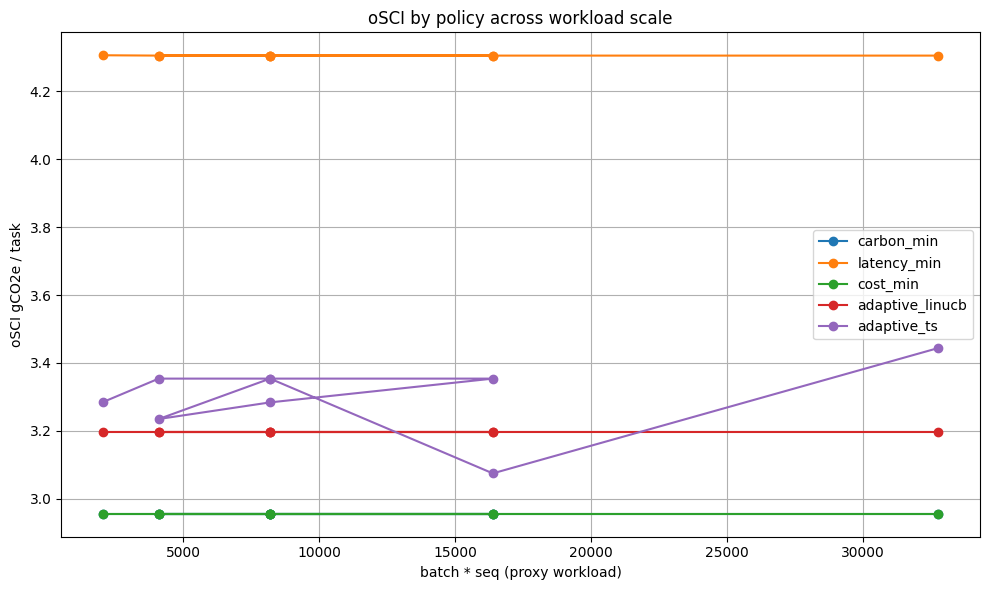

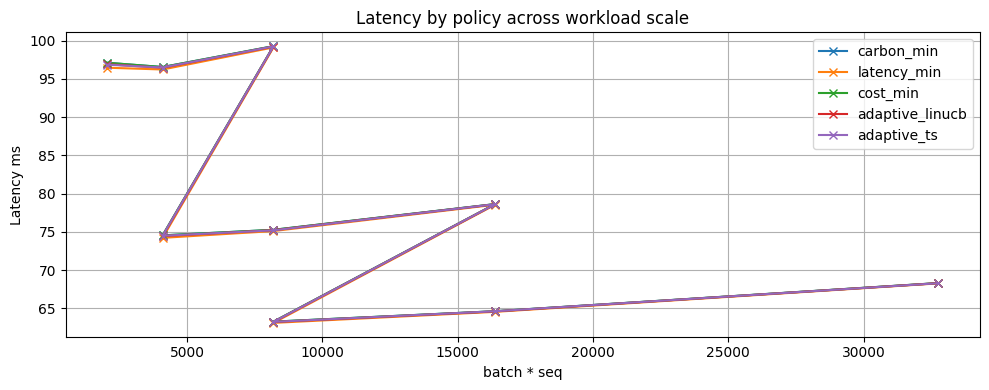

[codecarbon INFO @ 13:50:19] Energy consumed for RAM : 0.000013 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:50:19] Delta energy consumed for CPU with constant : 0.000038 kWh, power : 30.0 W
[codecarbon INFO @ 13:50:19] Energy consumed for All CPU : 0.000038 kWh
[codecarbon INFO @ 13:50:19] 0.000051 kWh of electricity used since the beginning.


=== SUMMARY ===
- Forecasting method used:  sma
- Meta-policies available: LinUCB and Thompson Sampling (contextual).
- Metric focus: oSCI (operational-only). Embodied carbon excluded.
- Offline emissions tracking via CodeCarbon:  ENABLED


In [11]:
"""
Innovative Hardware-Software Co-design for Energy-Efficient LLM Operations
Prototype v3: oSCI-focused adaptive scheduler with LinUCB + Thompson Sampling contextual bandits,
and ARIMA/Prophet forecasting (seasonality & holidays tuning).

Features added/fixed:
- Both LinUCB and Thompson Sampling contextual bandits implemented.
- Prophet forecasting uses seasonality and optional country holidays when available.
- Full, runnable script that prints per-run tables, policy summaries and shows matplotlib plots (no files saved).
- Optional CodeCarbon OfflineEmissionsTracker hook (no-op if not installed).

Run this script with Python 3.8+. If Prophet/ARIMA/CodeCarbon are not installed, the script falls back gracefully to SMA.
"""
from __future__ import annotations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from dataclasses import dataclass, field
from datetime import datetime, timedelta
from typing import Dict, List, Optional, Tuple
import logging
import json

warnings.filterwarnings("ignore")
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Optional dependencies
try:
    from prophet import Prophet  # type: ignore
    _HAS_PROPHET = True
except Exception:
    try:
        from fbprophet import Prophet  # type: ignore
        _HAS_PROPHET = True
    except Exception:
        _HAS_PROPHET = False

try:
    from statsmodels.tsa.arima.model import ARIMA  # type: ignore
    _HAS_ARIMA = True
except Exception:
    _HAS_ARIMA = False

try:
    from codecarbon import OfflineEmissionsTracker  # type: ignore
    _HAS_CODECARBON = True
except Exception:
    _HAS_CODECARBON = False

# -----------------------------------------------------------------------------
# Config
# -----------------------------------------------------------------------------
DATA_CENTERS = ['DC1', 'DC2', 'DC3']
TIME_SLOTS = 24
CARBON_INTENSITY_BASE = [500, 300, 700]
ENERGY_PRICE_BASE = [0.15, 0.10, 0.20]
WORKLOAD_ENERGY_PER_TASK_KWH = 0.01
BATCH_SIZES = [16, 32, 64]
SEQ_LENGTHS = [128, 256, 512]

LAMBDA_CARBON = 0.4
LAMBDA_LATENCY = 0.4
LAMBDA_COST = 0.2

LINUCB_ALPHA = 0.4

# -----------------------------------------------------------------------------
# Synthetic data generator
# -----------------------------------------------------------------------------

def generate_synthetic_data(seed: int = 42) -> Dict[str, pd.DataFrame]:
    rng = np.random.default_rng(seed)
    timestamps = [datetime.now() + timedelta(hours=i) for i in range(TIME_SLOTS)]
    carbon_data, price_data, workload_data = {}, {}, {}
    for dc, base_ci, base_price in zip(DATA_CENTERS, CARBON_INTENSITY_BASE, ENERGY_PRICE_BASE):
        carbon_series = [float(base_ci + 40*np.sin(i/24*2*np.pi) + rng.normal(0, 35)) for i in range(TIME_SLOTS)]
        price_series = [float(base_price + rng.normal(0, 0.015)) for _ in range(TIME_SLOTS)]
        workload_series = [int(rng.integers(10, 100)) for _ in range(TIME_SLOTS)]
        carbon_data[dc] = carbon_series
        price_data[dc] = price_series
        workload_data[dc] = workload_series
    return {
        'timestamps': timestamps,
        'carbon_intensity': pd.DataFrame(carbon_data, index=timestamps),
        'energy_prices': pd.DataFrame(price_data, index=timestamps),
        'workload_demand': pd.DataFrame(workload_data, index=timestamps)
    }

# -----------------------------------------------------------------------------
# Forecasting
# -----------------------------------------------------------------------------
@dataclass
class ForecastConfig:
    method: str = 'auto'  # 'sma' | 'arima' | 'prophet' | 'auto'
    window: int = 6

class Forecaster:
    def __init__(self, cfg: ForecastConfig = ForecastConfig()):
        self.cfg = cfg

    def _sma(self, series: pd.Series) -> float:
        w = min(self.cfg.window, len(series))
        if w <= 0:
            return float(series.iloc[-1])
        return float(series.iloc[-w:].mean())

    def _arima(self, series: pd.Series) -> float:
        if not _HAS_ARIMA or len(series) < 8:
            return self._sma(series)
        try:
            model = ARIMA(series.iloc[-self.cfg.window:], order=(1,1,0))
            fit = model.fit()
            fc = fit.forecast(steps=1)
            return float(fc.iloc[0])
        except Exception:
            return self._sma(series)

    def _prophet(self, series: pd.Series) -> float:
        if not _HAS_PROPHET or len(series) < 24:
            return self._sma(series)
        try:
            df = pd.DataFrame({
                'ds': pd.date_range(end=datetime.now(), periods=min(self.cfg.window, len(series)), freq='H'),
                'y': series.iloc[-self.cfg.window:].values
            })
            m = Prophet(
                growth='linear',
                daily_seasonality=True,
                weekly_seasonality=True,
                yearly_seasonality=False,
                seasonality_mode='multiplicative',
                changepoint_prior_scale=0.2,
                seasonality_prior_scale=10.0
            )
            # Try adding country holidays if available
            try:
                m.add_country_holidays(country_name='India')
            except Exception:
                pass
            # Fit and predict next hour
            m.fit(df)
            future = pd.DataFrame({'ds': [df['ds'].iloc[-1] + timedelta(hours=1)]})
            fc = m.predict(future)
            return float(fc['yhat'].iloc[0])
        except Exception:
            return self._sma(series)

    def _choose_method(self) -> str:
        if self.cfg.method in {'sma', 'arima', 'prophet'}:
            return self.cfg.method
        if _HAS_PROPHET:
            return 'prophet'
        if _HAS_ARIMA:
            return 'arima'
        return 'sma'

    def predict(self, data: Dict[str, pd.DataFrame], t: int) -> Dict[str, Dict[str, float]]:
        method = self._choose_method()
        f_carbon, f_prices, f_work = {}, {}, {}
        for dc in DATA_CENTERS:
            ci_hist = data['carbon_intensity'][dc].iloc[:max(1, t)]
            pr_hist = data['energy_prices'][dc].iloc[:max(1, t)]
            wd_hist = data['workload_demand'][dc].iloc[:max(1, t)]
            if method == 'sma':
                ci = self._sma(ci_hist)
                pr = self._sma(pr_hist)
                wd = self._sma(wd_hist)
            elif method == 'arima':
                ci = self._arima(ci_hist)
                pr = self._arima(pr_hist)
                wd = self._arima(wd_hist)
            else:
                ci = self._prophet(ci_hist)
                pr = self._prophet(pr_hist)
                wd = self._prophet(wd_hist)
            f_carbon[dc] = float(ci)
            f_prices[dc] = float(pr)
            f_work[dc] = float(wd)
        return {'carbon_intensity': f_carbon, 'energy_prices': f_prices, 'workload_demand': f_work}

# -----------------------------------------------------------------------------
# Policies
# -----------------------------------------------------------------------------

def carbon_minimizing_policy(workload: int, forecasts: Dict[str, Dict[str, float]], t: int) -> str:
    return min(forecasts['carbon_intensity'], key=forecasts['carbon_intensity'].get)

def latency_minimizing_policy(workload: int, forecasts: Dict[str, Dict[str, float]], t: int) -> str:
    return min(forecasts['workload_demand'], key=forecasts['workload_demand'].get)

def cost_minimizing_policy(workload: int, forecasts: Dict[str, Dict[str, float]], t: int) -> str:
    return min(forecasts['energy_prices'], key=forecasts['energy_prices'].get)

POLICY_PORTFOLIO = {'carbon_min': carbon_minimizing_policy, 'latency_min': latency_minimizing_policy, 'cost_min': cost_minimizing_policy}

# -----------------------------------------------------------------------------
# LinUCB
# -----------------------------------------------------------------------------
@dataclass
class LinUCBArm:
    A: np.ndarray
    b: np.ndarray
    @staticmethod
    def init(d: int) -> 'LinUCBArm':
        return LinUCBArm(A=np.eye(d), b=np.zeros((d,1)))
    def ucb(self, x: np.ndarray, alpha: float) -> float:
        A_inv = np.linalg.inv(self.A)
        mean = float((x.T @ A_inv @ self.b).ravel())
        bonus = float(np.sqrt(x.T @ A_inv @ x)) * alpha
        return mean + bonus
    def update(self, x: np.ndarray, r: float) -> None:
        self.A += x @ x.T
        self.b += x * r

class AdaptivePolicySelectorLinUCB:
    def __init__(self, d: int, alpha: float = LINUCB_ALPHA):
        self.alpha = alpha
        self.arms = {p: LinUCBArm.init(d) for p in POLICY_PORTFOLIO}
    def select(self, x: np.ndarray) -> str:
        scores = {p: arm.ucb(x,self.alpha) for p,arm in self.arms.items()}
        return max(scores.items(), key=lambda kv: kv[1])[0]
    def update(self, policy: str, x: np.ndarray, reward: float) -> None:
        self.arms[policy].update(x, reward)

# -----------------------------------------------------------------------------
# Thompson Sampling (Bayesian linear regression)
# -----------------------------------------------------------------------------
class AdaptivePolicySelectorTS:
    def __init__(self, d: int, lam: float = 1.0, sigma2: float = 0.1):
        self.d = d
        self.lam = lam
        self.sigma2 = sigma2
        self.A = {p: lam * np.eye(d) for p in POLICY_PORTFOLIO}
        self.b = {p: np.zeros((d,1)) for p in POLICY_PORTFOLIO}
        self.rng = np.random.default_rng(7)
    def _posterior(self, p: str):
        A = self.A[p]; b = self.b[p]
        A_inv = np.linalg.inv(A)
        mu = A_inv @ b
        Sigma = self.sigma2 * A_inv
        return mu, Sigma
    def select(self, x: np.ndarray) -> str:
        scores = {}
        for p in POLICY_PORTFOLIO:
            mu, Sigma = self._posterior(p)
            theta = self.rng.multivariate_normal(mean=mu.ravel(), cov=Sigma)
            scores[p] = float(x.ravel() @ theta)
        return max(scores.items(), key=lambda kv: kv[1])[0]
    def update(self, policy: str, x: np.ndarray, reward: float):
        self.A[policy] += (x @ x.T) / self.sigma2
        self.b[policy] += (x * reward) / self.sigma2

# -----------------------------------------------------------------------------
# Utilities: latency, reward, context
# -----------------------------------------------------------------------------
@dataclass
class RunResult:
    policy_or_adaptive: str
    batch_size: int
    seq_length: int
    avg_latency_ms_per_query: float
    throughput_tasks_per_sec: float
    energy_wh_per_task: float
    oSCI_gco2e_per_task: float

def simulate_latency_ms(forecasts: Dict[str, Dict[str, float]], dc: str, workload: int, batch_size: int, seq_length: int) -> float:
    base = 50.0
    demand_factor = 2.0 * (forecasts['workload_demand'][dc] / max(1.0, workload))
    seq_factor = 0.2 * (seq_length / 128)
    batch_gain = 40.0 / (batch_size / 16)
    latency = base + demand_factor * 10.0 + seq_factor * 10.0 + batch_gain
    return max(1.0, latency)

def compute_reward(energy_kwh_task: float, grid_ci_g_per_kwh: float, latency_ms: float, price_per_kwh: float) -> Tuple[float,float,float]:
    oSCI = energy_kwh_task * grid_ci_g_per_kwh
    cost = energy_kwh_task * price_per_kwh
    norm_carbon = oSCI / 100.0
    norm_latency = latency_ms / 100.0
    norm_cost = cost / 0.01
    reward = - (LAMBDA_CARBON * norm_carbon + LAMBDA_LATENCY * norm_latency + LAMBDA_COST * norm_cost)
    return float(reward), float(oSCI), float(cost)

def context_vector(forecasts: Dict[str, Dict[str, float]], batch_size: int, seq_length: int) -> np.ndarray:
    mc = np.mean(list(forecasts['carbon_intensity'].values())) / 1000.0
    mp = np.mean(list(forecasts['energy_prices'].values())) / 0.2
    ml = np.mean(list(forecasts['workload_demand'].values())) / 100.0
    bs = batch_size / 64.0
    sl = seq_length / 512.0
    x = np.array([[mc, mp, ml, bs, sl, 1.0]]).T
    return x.astype(float)

# -----------------------------------------------------------------------------
# Offline emissions tracker
# -----------------------------------------------------------------------------

def get_offline_tracker(project_name: str = "oscI-sim", country_iso_code: str = "IND"):
    if not _HAS_CODECARBON:
        class _Dummy:
            def start(self):
                return self
            def stop(self):
                return None
        logging.info("CodeCarbon not available; running without offline emissions tracking.")
        return _Dummy()
    try:
        tracker = OfflineEmissionsTracker(project_name=project_name, country_iso_code=country_iso_code)
        return tracker
    except Exception:
        class _Dummy:
            def start(self):
                return self
            def stop(self):
                return None
        logging.info("CodeCarbon could not initialize; running without tracker.")
        return _Dummy()

# -----------------------------------------------------------------------------
# Measurement loop
# -----------------------------------------------------------------------------

def measure_metrics(
    data: Dict[str, pd.DataFrame],
    forecaster: Forecaster,
    batch_size: int,
    seq_length: int,
    policy_name: str,
    device: str = 'cpu'
) -> Optional[RunResult]:
    try:
        selector_linucb = AdaptivePolicySelectorLinUCB(d=6) if policy_name == 'adaptive_linucb' else None
        selector_ts = AdaptivePolicySelectorTS(d=6) if policy_name == 'adaptive_ts' else None

        total_tasks = 0
        total_time_s = 0.0
        latency_samples: List[float] = []
        cum_energy_kwh = 0.0
        cum_oscI_g = 0.0

        for t in range(TIME_SLOTS):
            forecasts = forecaster.predict(data, t)
            base_demand = float(data['workload_demand'].iloc[t].mean())
            workload = max(1, int(base_demand * batch_size * seq_length / 512))

            if selector_ts is not None:
                x = context_vector(forecasts, batch_size, seq_length)
                chosen_policy = selector_ts.select(x)
                dc = POLICY_PORTFOLIO[chosen_policy](workload, forecasts, t)
            elif selector_linucb is not None:
                x = context_vector(forecasts, batch_size, seq_length)
                chosen_policy = selector_linucb.select(x)
                dc = POLICY_PORTFOLIO[chosen_policy](workload, forecasts, t)
            else:
                chosen_policy = policy_name
                dc = POLICY_PORTFOLIO[policy_name](workload, forecasts, t)

            latency_ms = simulate_latency_ms(forecasts, dc, workload, batch_size, seq_length)
            energy_kwh = WORKLOAD_ENERGY_PER_TASK_KWH * workload
            grid_ci = forecasts['carbon_intensity'][dc]
            price = forecasts['energy_prices'][dc]

            reward, oSCI_g, cost_dollars = compute_reward(
                energy_kwh_task=WORKLOAD_ENERGY_PER_TASK_KWH,
                grid_ci_g_per_kwh=grid_ci,
                latency_ms=latency_ms,
                price_per_kwh=price,
            )

            if selector_ts is not None:
                selector_ts.update(chosen_policy, x, reward)
            if selector_linucb is not None:
                selector_linucb.update(chosen_policy, x, reward)

            latency_samples.append(latency_ms)
            total_tasks += workload
            total_time_s += (latency_ms / 1000.0) * max(1, workload // batch_size)
            cum_energy_kwh += energy_kwh
            cum_oscI_g += oSCI_g * workload

        if total_tasks <= 0 or total_time_s <= 0:
            logging.error("No tasks or no time accumulated; check simulation params.")
            return None

        avg_latency = float(np.mean(latency_samples))
        throughput = float(total_tasks / total_time_s)
        energy_wh_per_task = (cum_energy_kwh / total_tasks) * 1000.0
        oSCI_g_per_task = float(cum_oscI_g / total_tasks)

        return RunResult(
            policy_or_adaptive=policy_name,
            batch_size=batch_size,
            seq_length=seq_length,
            avg_latency_ms_per_query=avg_latency,
            throughput_tasks_per_sec=throughput,
            energy_wh_per_task=energy_wh_per_task,
            oSCI_gco2e_per_task=oSCI_g_per_task,
        )
    except Exception as e:
        logging.exception(f"measure_metrics failed: {e}")
        return None

# -----------------------------------------------------------------------------
# Sweep
# -----------------------------------------------------------------------------

def run_batch_seq_scaling_study(device: str, policy_name: str, forecaster: Forecaster) -> List[RunResult]:
    data = generate_synthetic_data()
    results: List[RunResult] = []
    for b in BATCH_SIZES:
        for s in SEQ_LENGTHS:
            r = measure_metrics(data, forecaster, b, s, policy_name, device)
            if r is not None:
                logging.info(f"Completed: policy={policy_name}, batch={b}, seq={s}")
                results.append(r)
            else:
                logging.warning(f"Run failed: policy={policy_name}, batch={b}, seq={s}")
    return results

# -----------------------------------------------------------------------------
# Print & visualization
# -----------------------------------------------------------------------------

def print_results(results: List[RunResult]) -> None:
    if not results:
        print("No results.")
        return
    df = pd.DataFrame([{
        'policy': r.policy_or_adaptive,
        'batch': r.batch_size,
        'seq': r.seq_length,
        'latency_ms': round(r.avg_latency_ms_per_query, 3),
        'throughput_tps': round(r.throughput_tasks_per_sec, 3),
        'energy_Wh_task': round(r.energy_wh_per_task, 4),
        'oSCI_gCO2e_task': round(r.oSCI_gco2e_per_task, 3),
    } for r in results])
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 160):
        print("=== PER-RUN RESULTS ===")
        print(df)

    grouped = df.groupby('policy').mean(numeric_only=True)
    grouped = grouped[['latency_ms', 'throughput_tps', 'energy_Wh_task', 'oSCI_gCO2e_task']].round(3)
    print("=== AVERAGE BY POLICY ===")
    print(grouped)

    # simple plots
    try:
        plt.figure(figsize=(10,6))
        for p in df['policy'].unique():
            dff = df[df['policy']==p]
            plt.plot(dff['seq']*dff['batch'], dff['oSCI_gCO2e_task'], marker='o', label=p)
        plt.xlabel('batch * seq (proxy workload)')
        plt.ylabel('oSCI gCO2e / task')
        plt.title('oSCI by policy across workload scale')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(10,4))
        for p in df['policy'].unique():
            dff = df[df['policy']==p]
            plt.plot(dff['seq']*dff['batch'], dff['latency_ms'], marker='x', label=p)
        plt.xlabel('batch * seq')
        plt.ylabel('Latency ms')
        plt.title('Latency by policy across workload scale')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        logging.warning(f"Plotting failed: {e}")

# -----------------------------------------------------------------------------
# Main
# -----------------------------------------------------------------------------
if __name__ == '__main__':
    device = 'cpu'
    forecaster = Forecaster(ForecastConfig(method='auto', window=6))

    tracker = get_offline_tracker(project_name="oscI-sim-v3", country_iso_code="IND")
    tracker.start()

    policies = ['carbon_min', 'latency_min', 'cost_min', 'adaptive_linucb', 'adaptive_ts']
    all_results: List[RunResult] = []
    for p in policies:
        res = run_batch_seq_scaling_study(device, p, forecaster)
        all_results.extend(res)

    print_results(all_results)

    tracker.stop()

    print('=== SUMMARY ===')
    print('- Forecasting method used: ', forecaster._choose_method())
    print('- Meta-policies available: LinUCB and Thompson Sampling (contextual).')
    print('- Metric focus: oSCI (operational-only). Embodied carbon excluded.')
    print('- Offline emissions tracking via CodeCarbon: ', 'ENABLED' if _HAS_CODECARBON else 'DISABLED (lib not found)')
